#IMA PROJECT:
This project deals with ACE or Automatic Color Equalization.
We first implement the ACE algorithm on images respecting both the white patch and gray world hypothesis, then we observe the different results while varying the distance used and the r function used.
<br>
<br>In the second part of the project, we try to reduce the running time of ACE by adjusting each pixel according to a subset instead of the whole image, centered around said pixel.
<br>
<br> The final part consists of the implementation of an approximation of ACE, with an interpolation approach.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.pyplot as plt 

#r(.) Function:

Text(0, 0.5, 'r(x)')

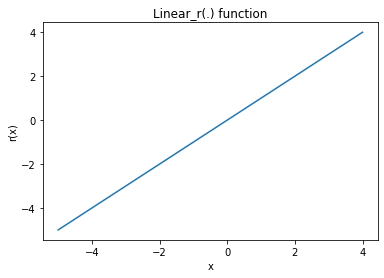

In [2]:
def linear_r(x):
  return x
plt.plot(np.arange(-5,5),linear_r(np.arange(-5,5)))
plt.title("Linear_r(.) function")
plt.xlabel("x")
plt.ylabel("r(x)")

Text(0, 0.5, 'r(x)')

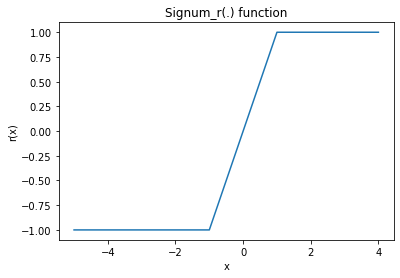

In [3]:
def signum_r(x):
  return np.sign(x)
plt.plot(np.arange(-5,5),signum_r(np.arange(-5,5)))
plt.title("Signum_r(.) function")
plt.xlabel("x")
plt.ylabel("r(x)")

Text(0, 0.5, 'r(x)')

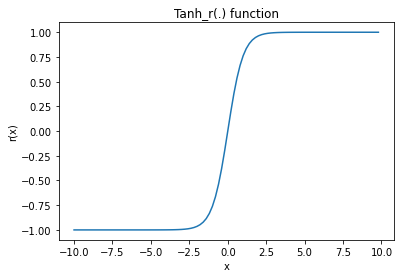

In [4]:
def tanh_r(x):
  return np.tanh(x)
plt.plot(np.arange(-10,10,0.2),tanh_r(np.arange(-10,10,0.2)))
plt.title("Tanh_r(.) function")
plt.xlabel("x")
plt.ylabel("r(x)")

In [5]:
def saturation_r(x, a):
  assert a>=1
  return np.minimum(1.0, np.maximum(x/a, -1.0))

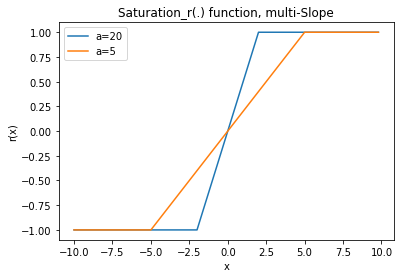

In [6]:
plt.plot(np.arange(-10,10,0.2),saturation_r(np.arange(-10,10,0.2),2), label="a=20")
plt.plot(np.arange(-10,10,0.2),saturation_r(np.arange(-10,10,0.2),5), label="a=5")
plt.title("Saturation_r(.) function, multi-Slope")
plt.xlabel("x")
plt.ylabel("r(x)")
plt.legend(loc="upper left")

In [7]:
def r(x, a=1, nom_r="tanh"):
  if nom_r=="linear":
    return linear_r(x)
  elif nom_r=="signum":
    return signum_r(x)
  elif nom_r=="tanh":
    return tanh_r(x)
  elif nom_r=="saturation":
    try:
      return saturation_r(x, a)
    except:
      raise Exception("insert the slope of saturation function")

#Distance d(.) Function:

In [8]:
def Euclidian_distance(dx,dy):
  return np.sqrt(dx**2+dy**2)
def inverse_exp(dx,dy,alpha=1):
  return(1/np.exp(-alpha*Euclidian_distance(dx,dy)))
def manhattan(dx,dy):
  return dx+dy

def d(dx,dy,distance):
  if distance=='Euclidian':
    return Euclidian_distance(dx,dy)
  elif distance=='inverse exp':
    return inverse_exp(dx,dy)
  elif distance=='manhattan':
    return manhattan(dx,dy)
  elif distance=='maximum':
    return max(dx,dy)
  else:
    print("give a name in (Euclidian, inverse exp, manhattan, maximum")

#Getting the maximum value of the r(.) function: rmax:

In [9]:
!pip install scipy
import scipy
from scipy.optimize import minimize, rosen, rosen_der
def rmax(nom_r):
  max_x = scipy.optimize.fmin(lambda x: -r(x,nom_r), 0)
  return r(max_x[0], nom_r)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#PART 1 : IMPLEMENTING BASIC ACE :

##Getting Rc intermediate image:

In [10]:
def rescale(img):
  return np.interp(img, (img.min(), img.max()), (0, +1))

In [11]:
def Rc_pixel(p,k, distance ,file_name, rm,nom_r='tanh'):
  a,b= p[0] , p[1]
  Ic = plt.imread(file_name)
  c=0
  s=0
  I = rescale(Ic[:,:,k])
  for i in range(I.shape[0]):
    for j in range(I.shape[1]):
      try:
        if i!=a or j!=b:
          dx= abs(a-i)
          dy= abs(b-j)
          c+= r(I[a][b]-I[i][j],nom_r)/d(dx,dy,distance)
          s+=rm/d(dx,dy,distance)
      except:
        pass
  return c/s

In [12]:
def Rc_all (file_name, distance, nom_r='tanh'):
  print(nom_r)
  Ic= plt.imread(file_name,1)
  rm=rmax(nom_r)
  Rc=np.zeros((Ic.shape[0],Ic.shape[1],Ic.shape[2]))
  for k in range(3):
    for i in range (Ic.shape[0]):
      for j in range(Ic.shape[1]):
        Rc[i][j][k]= Rc_pixel([i,j],k, distance, file_name,rm, nom_r)
  return(Rc)

##Rescaling: Final Oc image:

In [13]:
#Getting slope:
def sc(mc, Mc):
  assert Mc!=mc
  slope = 255/(Mc-mc)
  return slope

Linear scaling:

In [14]:
def linear_scaling_pixel(Rc,p,k,sc,mc):
  i,j= p[0],p[1]
  return round(sc*(Rc[i][j][k]-mc))

def linear_scaling(Rc):
  Oc=np.zeros((Rc.shape[0],Rc.shape[1],3))
  for c in range(3):
    mc=Rc[:,:,c].min()
    Mc=Rc[:,:,c].max()
    slope = sc(mc,Mc)
    for i in range(Rc.shape[0]):
      for j in range(Rc.shape[1]):
        Oc[i][j][c]=linear_scaling_pixel(Rc,[i,j],c,slope,mc)
  return(Oc)

White gray world rescaling:

In [15]:
def whitegrayworld_pixel(Rc,p,k,sc):
  i,j=p[0],p[1]
  return round(127.5+sc*Rc[i][j][k])

def whitegrayworld(Rc):
  Oc=np.zeros((Rc.shape[0],Rc.shape[1],3))
  for c in range(3):
    mc=Rc[:,:,c].min()
    Mc=Rc[:,:,c].max()
    slope = sc(mc,Mc)
    for i in range(Rc.shape[0]):
      for j in range(Rc.shape[1]):
        Oc[i][j][c]=whitegrayworld_pixel(Rc,[i,j],c,slope)
  return(Oc)

##TEST ON MULTIPLE EXAMPLES:

###VERIFICATION OF GRAY WORLD / WHITE PATCH CONDITIONS:

In [ ]:
from PIL import Image, ImageStat


[59.89983685800604, 113.70675528700906, 80.16818126888218]


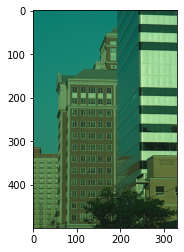

In [ ]:
img = plt.imread('/content/original_size/building.jpg')
plt.imshow(img)
image= Image.open('/content/original_size/building.jpg')
stat = ImageStat.Stat(image)
print(stat.mean)

[108.85980120481928, 75.81401807228916, 43.711090361445784]


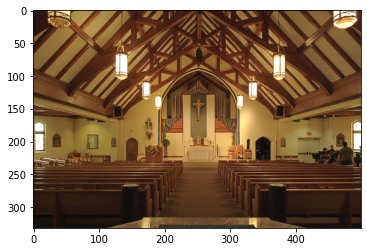

In [ ]:
img = plt.imread('/content/original_size/church.jpg')
plt.imshow(img)
image= Image.open('/content/original_size/church.jpg')
stat = ImageStat.Stat(image)
print(stat.mean)

[97.70415060240964, 58.11234337349398, 32.11372289156626]


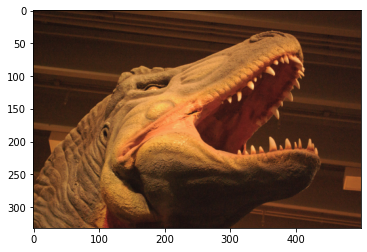

In [ ]:
img = plt.imread('/content/original_size/dino.jpg')
plt.imshow(img)
image= Image.open('/content/original_size/dino.jpg')
stat = ImageStat.Stat(image)
print(stat.mean)

[99.94304791666667, 121.36034375, 135.22168541666667]


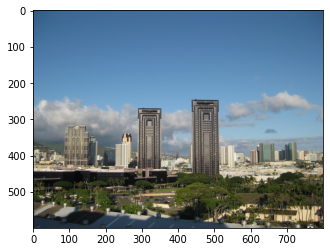

In [ ]:
img = plt.imread('/content/original_size/hawaii.png')
plt.imshow(img)
image= Image.open('/content/original_size/hawaii.png')
stat = ImageStat.Stat(image)
print(stat.mean)

[45.16435975609756, 88.10549390243902, 62.49493902439024]


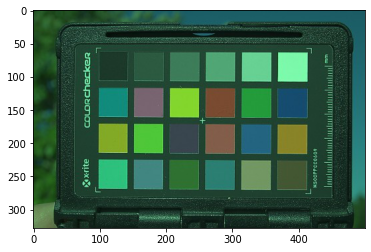

In [ ]:
img = plt.imread('/content/original_size/palette.jpg')
plt.imshow(img)
image= Image.open('/content/original_size/palette.jpg')
stat = ImageStat.Stat(image)
print(stat.mean)

[141.75481927710842, 145.45143975903613, 80.99153012048193]


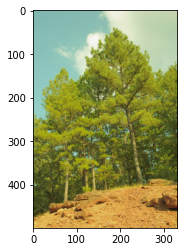

In [ ]:
img = plt.imread('/content/original_size/tree.jpg')
plt.imshow(img)
image= Image.open('/content/original_size/tree.jpg')
stat = ImageStat.Stat(image)
print(stat.mean)

### TESTS:

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


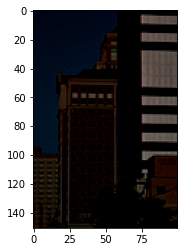

In [ ]:
Rc= Rc_all('/content/small_images/building.jpg', 'Euclidian')
plt.imshow(Rc)

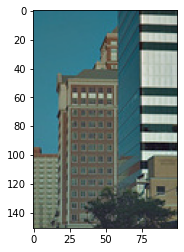

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

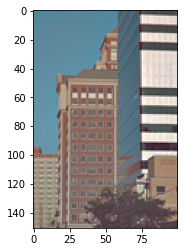

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


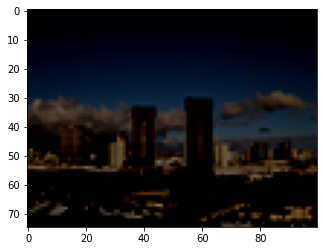

In [ ]:
Rc= Rc_all('/content/small_images/hawaii.png', 'Euclidian')
plt.imshow(Rc)

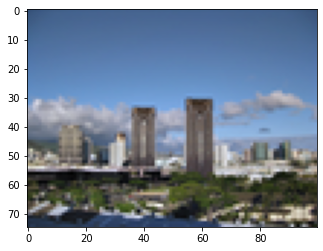

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

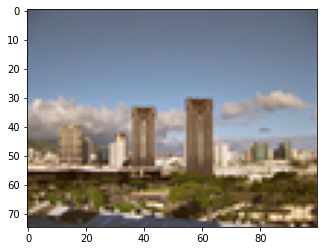

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


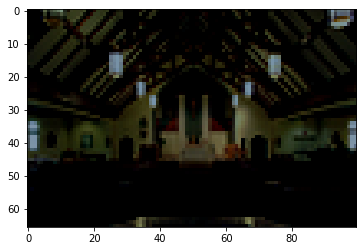

In [ ]:
Rc= Rc_all('/content/small_images/church.jpg', 'Euclidian')
plt.imshow(Rc)

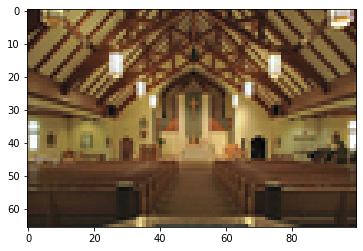

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

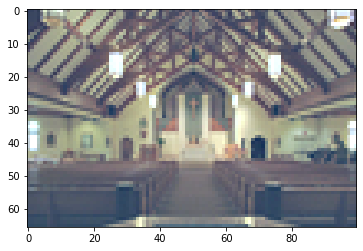

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

In [ ]:
Rc= Rc_all('/content/dog.png', 'Euclidian')

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84
k= 0
k= 1
k= 2


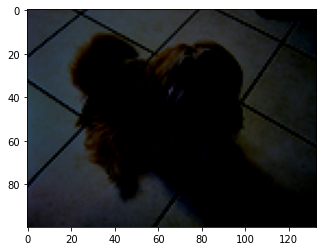

In [ ]:
Rc = Rc[:,:,:3]
plt.imshow(Rc)

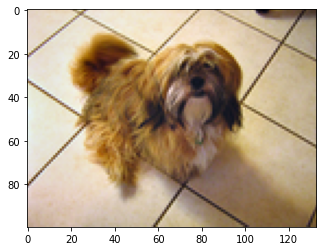

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

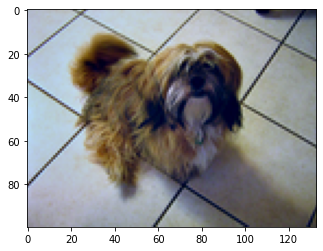

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

In [ ]:
Rc= Rc_all('/content/tree.jpg', 'Euclidian')

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84
k= 0
k= 1
k= 2


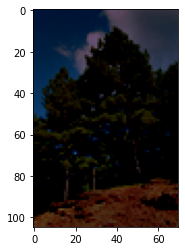

In [ ]:
Rc = Rc[:,:,:3]
plt.imshow(Rc)

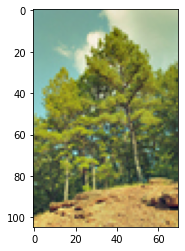

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

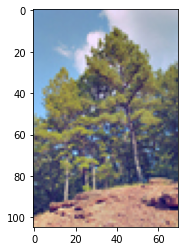

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

In [ ]:
Rc= Rc_all('/content/dino.jpg', 'Euclidian')

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84
k= 0
k= 1
k= 2


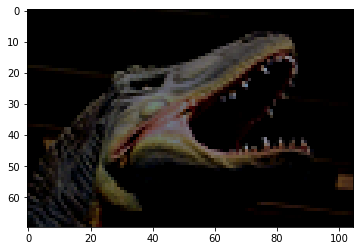

In [ ]:
Rc = Rc[:,:,:3]
plt.imshow(Rc)

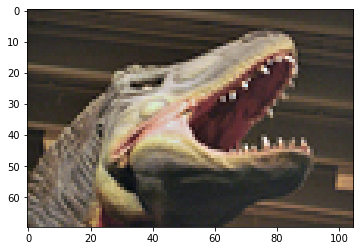

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

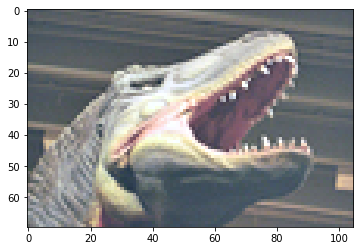

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

In [ ]:
Rc= Rc_all('/content/cathedral.png', 'Euclidian')

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84
k= 0
k= 1
k= 2


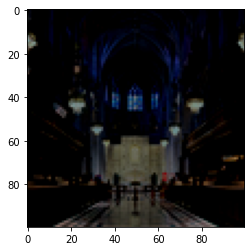

In [ ]:
Rc = Rc[:,:,:3]
plt.imshow(Rc)

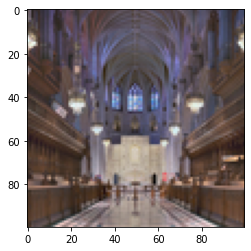

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

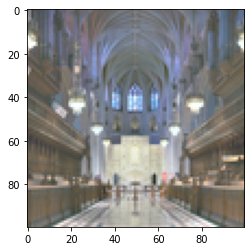

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

##TEST WHILE CHANGING DISTANCE :

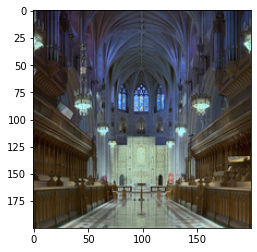

In [ ]:
img = plt.imread('/content/cathedral-GW-bradford.png')
plt.imshow(img)

###Euclidian Distance :

In [ ]:
Rc= Rc_all('/content/cathedral-GW-bradford.png', 'Euclidian')

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


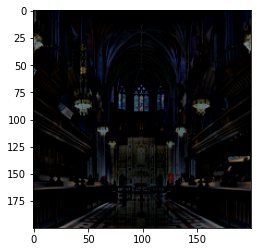

In [ ]:
plt.imshow(Rc)

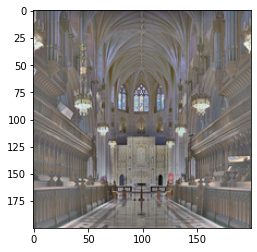

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

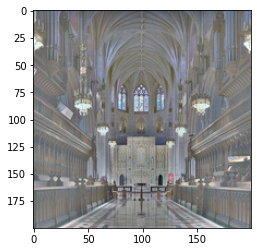

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

###Inverse exponential:

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


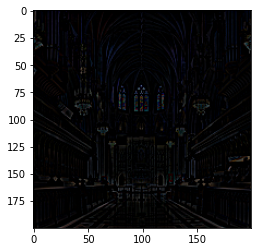

In [ ]:
Rc1= Rc_all('/content/cathedral-GW-bradford.png', 'inverse exp')
np.save('cathedral100_inverseexp_Rc',Rc1)
plt.imshow(Rc1)

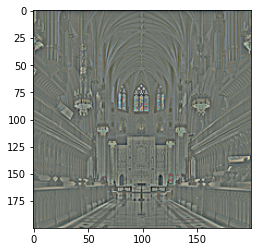

In [ ]:
Oc1 = linear_scaling(Rc1).astype('int32')
plt.imshow(Oc1)

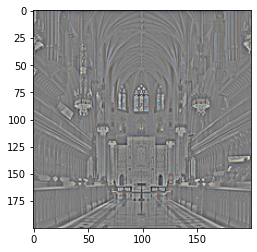

In [ ]:
wgw = whitegrayworld(Rc1).astype('int32')
plt.imshow(wgw)

###Manhattan:

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


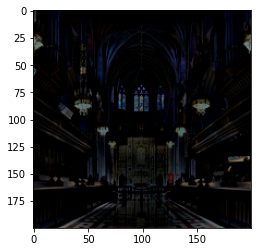

In [ ]:
Rc2= Rc_all('/content/cathedral-GW-bradford.png', 'manhattan')
np.save('cathedral100_manhattan_Rc',Rc2)
plt.imshow(Rc2)

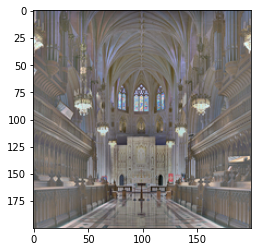

In [ ]:
Oc2 = linear_scaling(Rc2).astype('int32')
plt.imshow(Oc2)

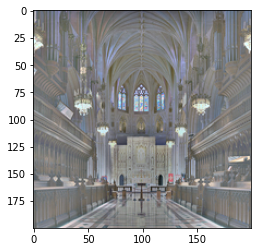

In [ ]:
wgw = whitegrayworld(Rc2).astype('int32')
plt.imshow(wgw)

###Maximum:

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


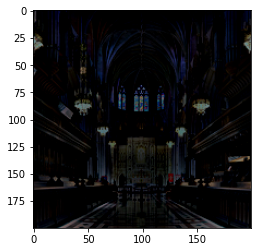

In [ ]:
Rc3= Rc_all('/content/cathedral-GW-bradford.png', 'maximum')
np.save('cathedral100_max_Rc',Rc3)
plt.imshow(Rc3)

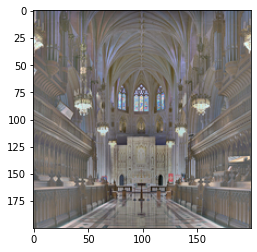

In [ ]:
Oc3 = linear_scaling(Rc3).astype('int32')
plt.imshow(Oc3)

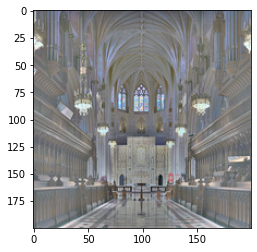

In [ ]:
wgw = whitegrayworld(Rc3).astype('int32')
plt.imshow(wgw)

##TEST WHILE CHANGING r(.) FUNCTION :

In [ ]:
Rc= Rc_all_subset (20,'/content/316243171_435880235401909_8409203169192456619_n.png', 'Euclidian','signum')

signum
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


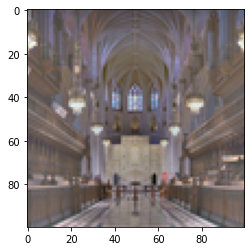

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

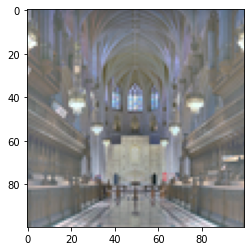

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

In [ ]:
Rc= Rc_all_subset (20,'/content/316243171_435880235401909_8409203169192456619_n.png', 'Euclidian','linear')

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


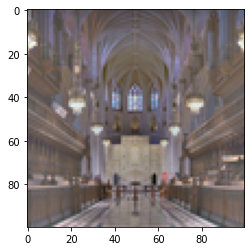

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

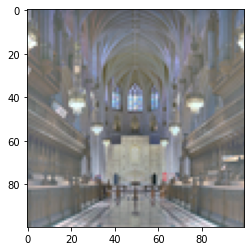

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

tanh
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


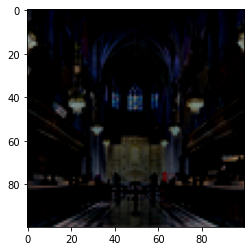

In [ ]:
Rc= Rc_all_subset(20, '/content/cathedral.png', 'Euclidian') #r=tanh
plt.imshow(Rc)

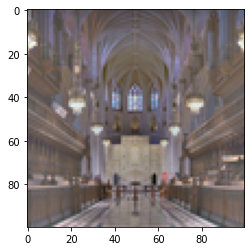

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

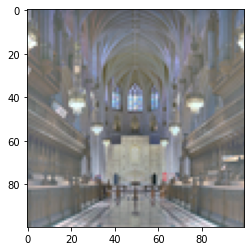

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

saturation
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


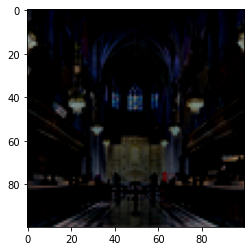

In [ ]:
Rc= Rc_all_subset(20, '/content/cathedral.png', 'Euclidian','saturation')
plt.imshow(Rc)

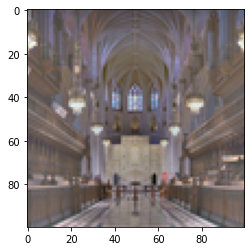

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

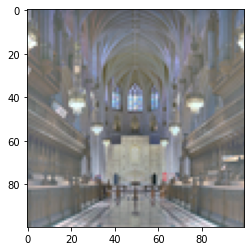

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

#PART 2 : USING A SUBSET TO REDUCE RUNNING TIME :

#Determine the best subset with loss no more than 10%

In [ ]:
def Window_Rc_pixel(p, distance, file_name, rm, nom_r='tanh'):
  a,b= p[0] , p[1]
  Ic = plt.imread(file_name)
  I = rescale(Ic[:,:,0])
  dct = dict()
  for n in range(5,I.shape[0],5):
    for m in range(5,I.shape[1],5):
      c=0
      s=0
      for i in range(n):
        for j in range(m):
          if i!=a or j!=b:
            dx= abs(a-i)
            dy= abs(b-j)
            s+=rm/d(dx,dy,distance)
      dct[(n,m)] = s
  return dct

In [ ]:
file_name = '/content/cathedral.png'
Ic= plt.imread(file_name,1)
rm = 1 #rm = rmax('tanh')
i = 0
j = 0
dct = Window_Rc_pixel([i,j], 'Euclidian', file_name, rm, 'tanh')
dct

In [ ]:
value = {i for i in dct if dct[i]==np.quantile(list(dct.values()), 0.9)}
value

{(70, 80)}

#Results on a subset 

In [16]:
def Rc_pixel_subset(p,k,n, distance ,file_name, rm,nom_r='tanh'):
  a,b= p[0] , p[1]
  Ic = plt.imread(file_name)
  c=0
  s=0
  I = rescale(Ic[:,:,k])
  for i in range(a-n, a+n+1):
    for j in range(b-n, b+n+1):
      try:
        if i!=a or j!=b:
          dx= abs(a-i)
          dy= abs(b-j)
          c+= r(I[a][b]-I[i][j],nom_r)/d(dx,dy,distance)
          s+=rm/d(dx,dy,distance)
      except:
        pass
  return c/s

In [17]:
def Rc_all_subset (n,file_name, distance, nom_r='tanh'):
  print(nom_r)
  Ic= plt.imread(file_name,1)
  rm=rmax(nom_r)
  Rc=np.zeros((Ic.shape[0],Ic.shape[1],Ic.shape[2]))
  for k in range(3):
    for i in range (Ic.shape[0]):
      for j in range(Ic.shape[1]):
        Rc[i][j][k]= Rc_pixel_subset([i,j],k,n, distance, file_name,rm, nom_r)
  return(Rc)

##TEST WITH SUBSETS:

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


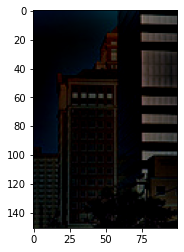

In [ ]:
Rc= Rc_all_subset(20, '/content/small_images/building.jpg', 'Euclidian')
plt.imshow(Rc)

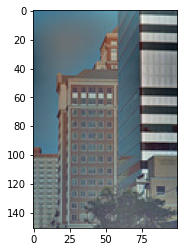

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

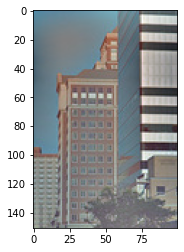

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


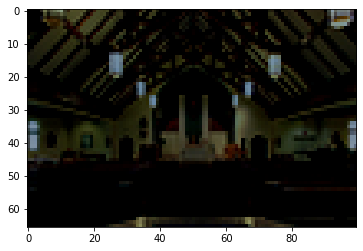

In [ ]:
Rc= Rc_all_subset(20, '/content/small_images/church.jpg', 'Euclidian')
plt.imshow(Rc)

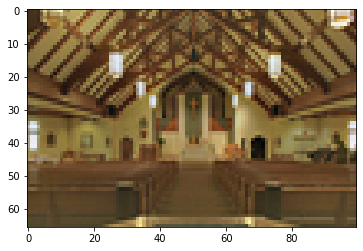

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

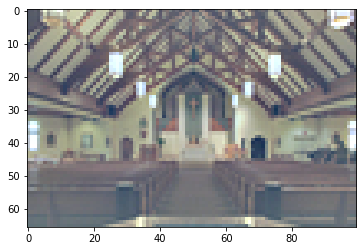

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


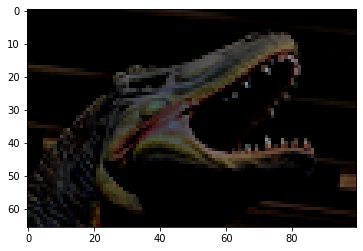

In [ ]:
Rc= Rc_all_subset(20, '/content/small_images/dino.jpg', 'Euclidian')
plt.imshow(Rc)

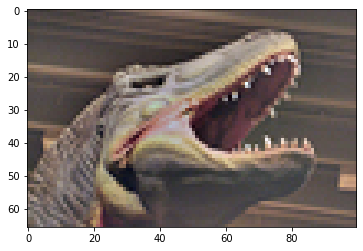

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

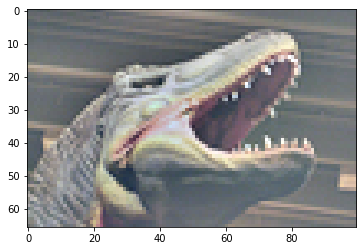

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


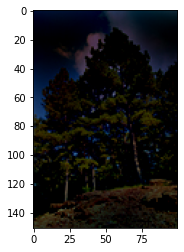

In [ ]:
Rc= Rc_all_subset(20, '/content/small_images/tree.jpg', 'Euclidian')
plt.imshow(Rc)

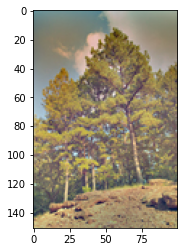

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

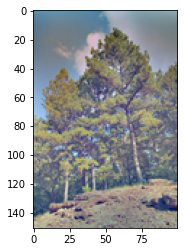

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


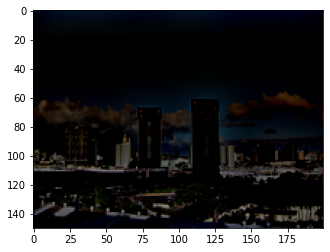

In [ ]:
Rc= Rc_all_subset(20, '/content/200/hawaii.png', 'Euclidian')
plt.imshow(Rc)

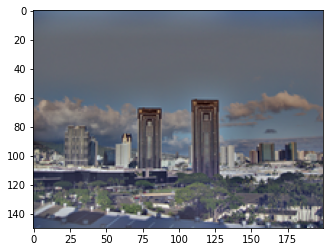

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

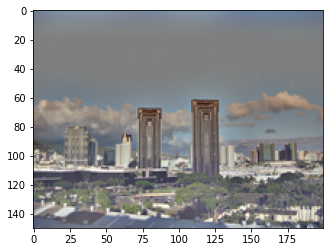

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


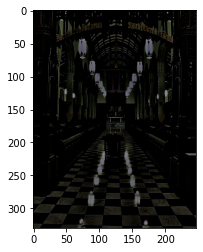

In [ ]:
Rc= Rc_all_subset(20, '/content/Before and After.jpg', 'Euclidian')
plt.imshow(Rc)

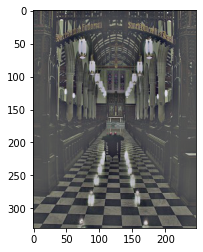

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

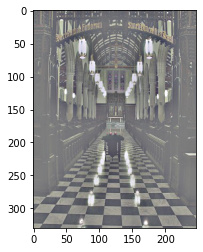

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

linear
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


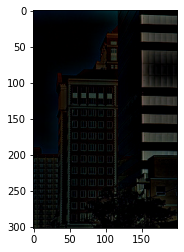

In [ ]:
Rc= Rc_all_subset(20, '/content/200/building.jpg', 'Euclidian')
plt.imshow(Rc)

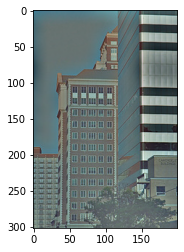

In [ ]:
Oc = linear_scaling(Rc).astype('int32')
plt.imshow(Oc)

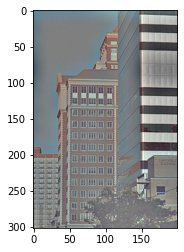

In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

In [ ]:
#test with best subset size:
Rc= Rc_all_subset(70, '/content/316243171_435880235401909_8409203169192456619_n.png', 'Euclidian')
plt.imshow(Rc)

tanh
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 34
         Function evaluations: 84


In [ ]:
wgw = whitegrayworld(Rc).astype('int32')
plt.imshow(wgw)

#Histograms

In [ ]:
img.ravel()

array([0.9607843 , 0.8117647 , 0.5294118 , ..., 0.4509804 , 0.28627452,
       0.09803922], dtype=float32)

In [ ]:
histogram, bin_edges = np.histogram(wgw, bins=256, range=(0, 1))

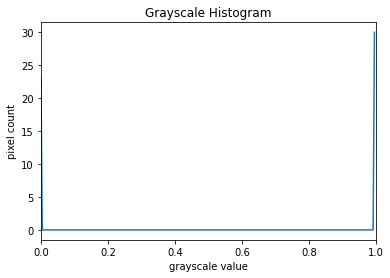

In [ ]:
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here

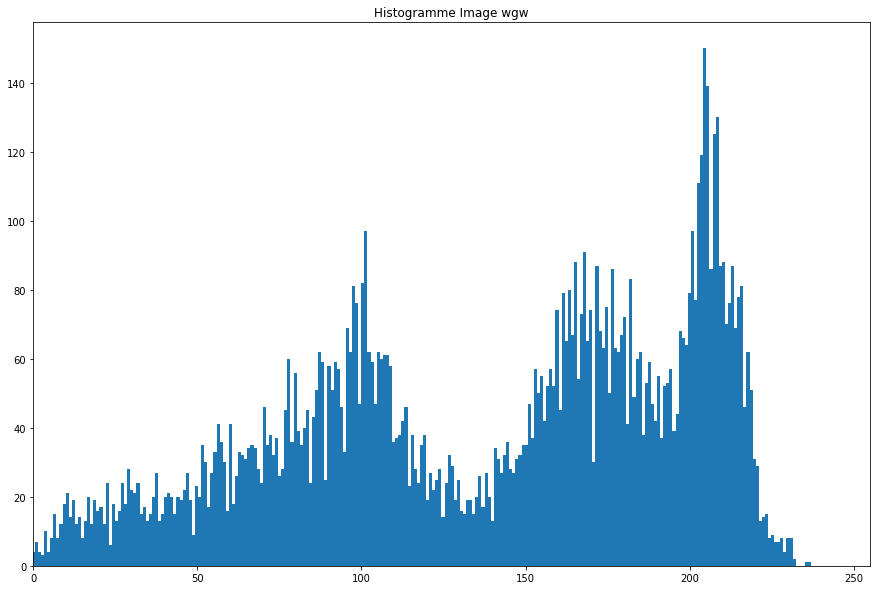

In [ ]:
import matplotlib.pyplot as plt
import cv2


# calculate mean value from RGB channels and flatten to 1D array
vals = wgw.mean(axis=2).flatten()
plt.figure(figsize=(15,10))
# plot histogram with 255 bins
b, bins, patches = plt.hist(vals, 255)
plt.xlim([0,255])
plt.title("Histogramme Image wgw")
plt.show()

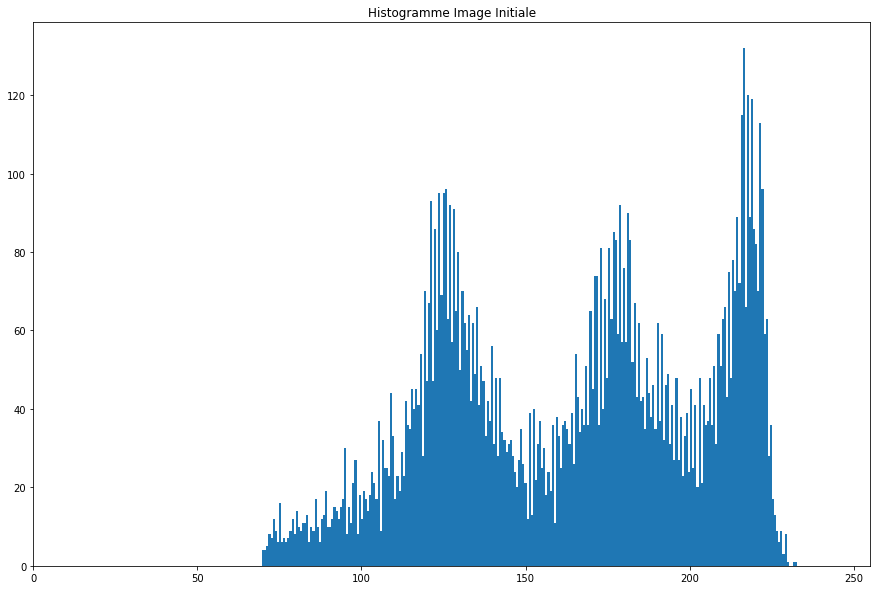

In [ ]:
img2 = plt.imread("/content/doge1.png", 1)
vals = img2.mean(axis=2).flatten()
plt.figure(figsize=(15,10))
# plot histogram with 255 bins
b, bins, patches = plt.hist(vals, 255)
plt.xlim([0,255])
plt.title("Histogramme Image Initiale")
plt.show()

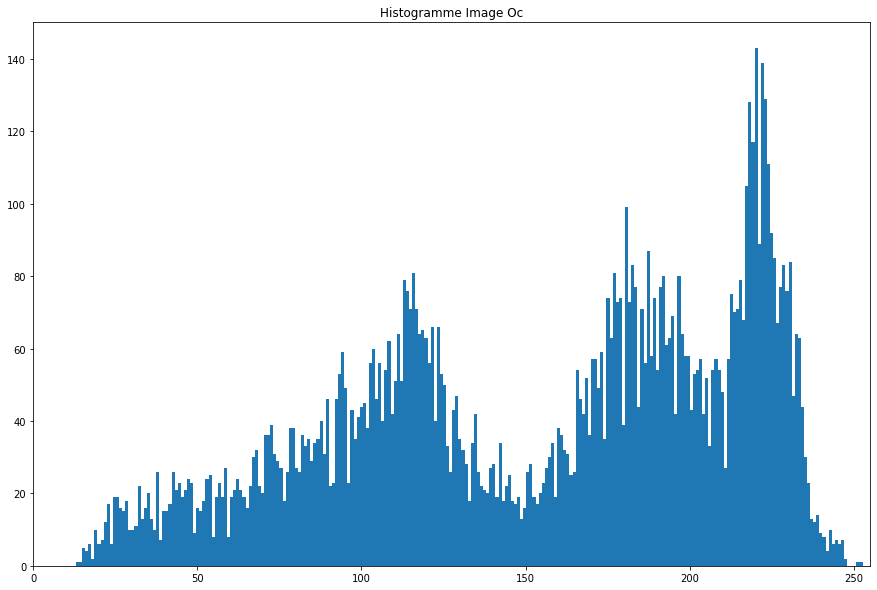

In [ ]:
vals = Oc.mean(axis=2).flatten()
plt.figure(figsize=(15,10))
# plot histogram with 255 bins
b, bins, patches = plt.hist(vals, 255)
plt.xlim([0,255])
plt.title("Histogramme Image Oc")
plt.show()

In [ ]:
img2 = plt.imread("/content/doge1.png", 1)

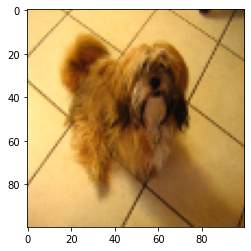

In [ ]:
plt.imshow(img2)